In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random

Need to make the function `test_bootstrap_universal` work for weighted and directed graphs

In [127]:
"""homogenous weighted SBM code (from my project, is Bernoulli trials)"""
# Network generation --------------------------------------------------------
random.seed(10)

n = 300  # number of nodes
K = 2     # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []
B_list.append(np.array([[0.4, 0.2], [0.2, 0.7]]))


In [128]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [129]:
random.seed(10)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
"""Have modified this to be a draw for integers between 0 and 10 for no. connections"""
A_t = np.random.binomial(n=10, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

As = As.astype(int)
P = np.column_stack(P_list)

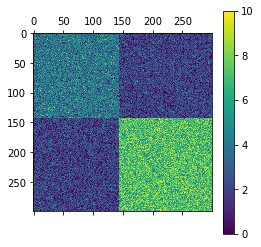

In [130]:
# Sample drawn using the above P in a Binom(10, P) - this is the Observed A matrix
cax = plt.matshow(As)
plt.colorbar(cax)
plt.show()

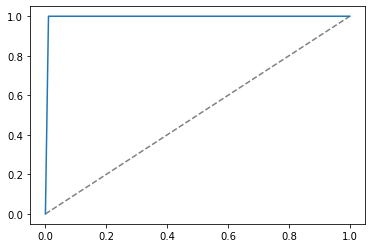

1.0

In [131]:
A_obs = As.astype(float)
p_vals, A_boots = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_boots[0]

plot_power(p_vals, plot=True)

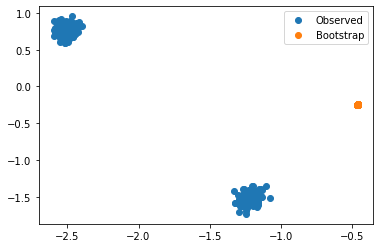

In [132]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

Now need to make this work, cos the test_bootstrap function doesn't do anything with weights

In [133]:
def multiply_with_weights(A, w1, w2):
    # Reshape w1 and w2 to have dimensions (n, 1)
    w1_reshaped = w1[:, np.newaxis]  # shape (n, 1)
    w2_reshaped = w2[np.newaxis, :]  # shape (1, n)
    
    # Perform element-wise multiplication
    M = w1_reshaped * w2_reshaped * A
    
    return M

In [134]:
A = A_obs
d=2
n_neighbors=5
B = 100

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the "weighted" P matrix (idk how you'd sample from this) -------------------------------
P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Adjusted P_est matrix ( not sure if this will be in [0,1]) -------------------------------
P_est_adj = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if (out_weights[i]*in_weights[j]) == 0:
            P_est_adj[i,j] = 0
        else:
            P_est_adj[i,j] = (1/(np.sqrt((out_weights[i]*in_weights[j])))) * P_est[i,j]

# Check matrix range
check_matrix_range(P_est_adj)

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_adj = make_inhomogeneous_rg(P_est_adj)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_adj)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

Matrix values are within the range [0, 1].


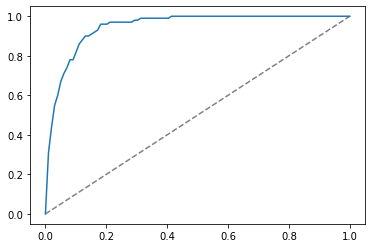

0.67

In [135]:
plot_power(p_vals, plot=True)

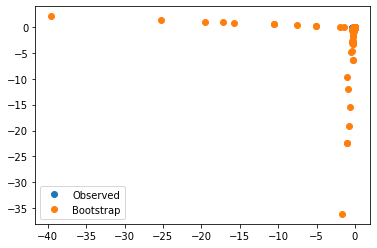

In [136]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

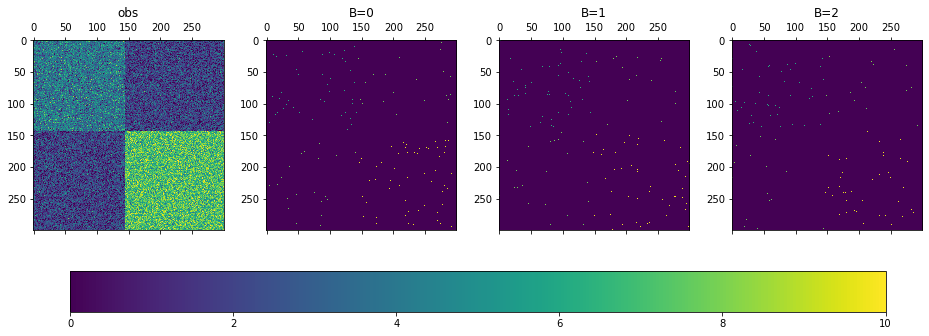

In [137]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

In [158]:
"""method 2"""
n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Binarise A using a threshold -------------------------------
quantile_75 = np.quantile(A, q=0.75)
quantile = np.quantile(A, q=0.5)
A_bin = np.where(A > quantile, 1, 0)

# Estimate the binarised P from the binarised A -------------------------------
P_est_bin = P_est_from_A_obs(n, A_bin, n_neighbors=n_neighbors, indices=indices)

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_bin = make_inhomogeneous_rg(P_est_bin)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_bin)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

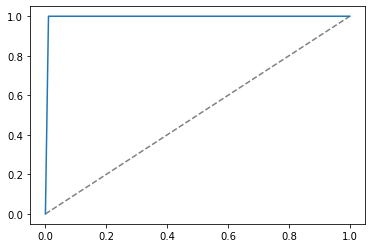

1.0

In [159]:
plot_power(p_vals, plot=True)

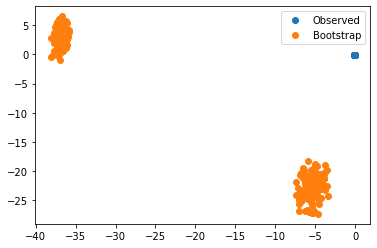

In [160]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

In [161]:
# append A_obs to the front of A_boots list
mats = [A_obs] + A_boots
len(mats)


101

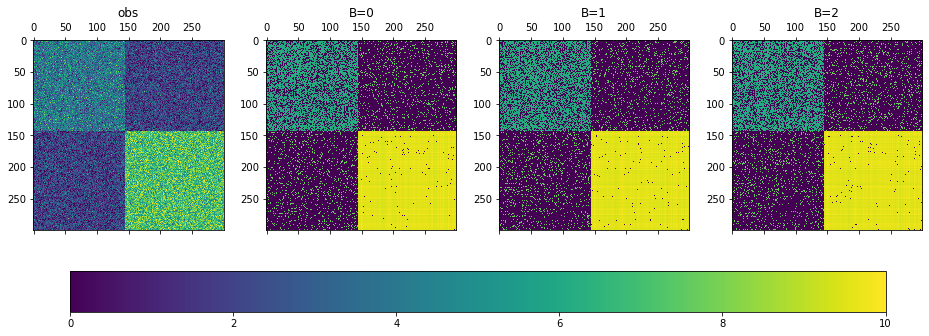

In [162]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

In [163]:
"""method 3"""
"""method 2"""
n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the binarised P from the binarised A -------------------------------
P_est = P_est_from_A_obs(n, A, n_neighbors=n_neighbors, indices=indices)
pmax = np.max(P_est_bin)
P_est_adj = P_est/pmax

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_adj = make_inhomogeneous_rg(P_est_adj)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_adj)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

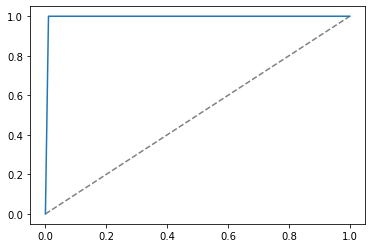

1.0

In [164]:
plot_power(p_vals, plot=True)

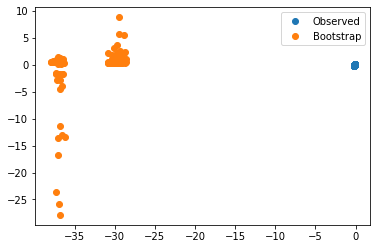

In [165]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

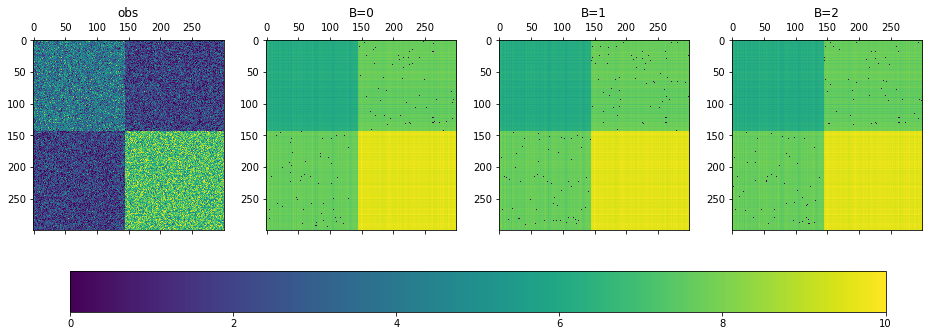

In [166]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')